In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.37MB/s]


In [ ]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim

        # --------- Encoder ---------
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # [B, 64, 7, 7]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # [B, 128, 4, 4]
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # --------- Decoder ---------
        self.fc_decode = nn.Linear(latent_dim, 128*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # [B, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # [B, 1, 32, 32]
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h_flat = self.flatten(h)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 128, 4, 4)
        x_hat = self.decoder(h)
        return x_hat[:, :, :28, :28]  # Crop to MNIST size

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [ ]:
def beta_vae_loss(x, x_hat, mu, logvar, beta=4.0):
    # Reconstruction loss: binary cross entropy
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    # KL divergence between q(z|x) and N(0,I)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_div, recon_loss, kl_div

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BetaVAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
beta = 4.0
losses, recons, kls = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    for batch in train_loader:
        x, _ = batch
        x = x.to(device)

        x_hat, mu, logvar = model(x)
        loss, recon, kl = beta_vae_loss(x, x_hat, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

    losses.append(total_loss / len(train_loader.dataset))
    recons.append(total_recon / len(train_loader.dataset))
    kls.append(total_kl / len(train_loader.dataset))

    print(f"Epoch {epoch+1}, Loss: {losses[-1]:.2f}, Recon: {recons[-1]:.2f}, KL: {kls[-1]:.2f}")

Epoch 1, Loss: 184.24, Recon: 162.34, KL: 5.47
Epoch 2, Loss: 153.80, Recon: 118.69, KL: 8.78
Epoch 3, Loss: 150.15, Recon: 113.19, KL: 9.24
Epoch 4, Loss: 148.37, Recon: 110.56, KL: 9.45
Epoch 5, Loss: 147.24, Recon: 108.96, KL: 9.57
Epoch 6, Loss: 146.36, Recon: 107.71, KL: 9.66
Epoch 7, Loss: 145.82, Recon: 106.75, KL: 9.77
Epoch 8, Loss: 145.25, Recon: 106.00, KL: 9.81
Epoch 9, Loss: 144.84, Recon: 105.38, KL: 9.86
Epoch 10, Loss: 144.38, Recon: 104.78, KL: 9.90


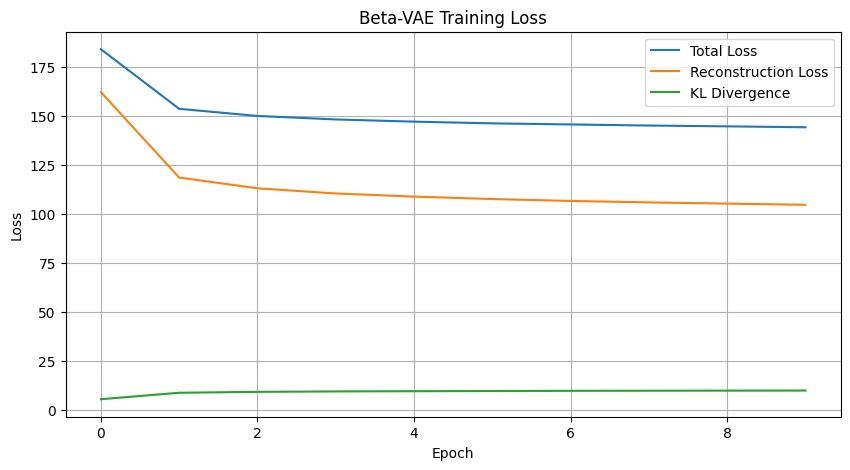

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(losses, label='Total Loss')
plt.plot(recons, label='Reconstruction Loss')
plt.plot(kls, label='KL Divergence')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Beta-VAE Training Loss")
plt.grid(True)
plt.show()

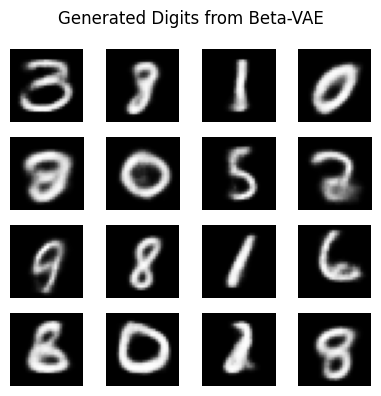

In [ ]:
def generate_images(model, num_images=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        samples = model.decode(z)
    return samples.cpu()

samples = generate_images(model)

# Plot generated digits
plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i][0], cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Digits from Beta-VAE")
plt.tight_layout()
plt.show()